In [1]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
# Constants
GAMMA = 0.99

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [3]:
def update_policy(policy_network, trajectories_gradient):
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(trajectories_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [4]:
def count_trajectory(rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [5]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [9]:
def cart_pole(n_trajectories = 2, episode_num = 1500):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)

    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]

    for episode in range(max_episode_num):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            
            for steps in range(max_steps):
                #env.render()
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                
                if done:
                    traj = count_trajectory(rewards[trajectory], log_probs)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state
                
        #print('Updating...')
        update_policy(policy_net, r_gradient)                 
        rewards = align_columns_zeros(rewards)
        #print(all_rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average reward among trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
        
    return all_rewards, avg_numsteps 

In [10]:
%%time
all_rewards, mean_rewards = cart_pole(2, 2000)

episode: 0, total mean reward among trajectories: 30.5, average reward among trajectories: 30.5
episode: 10, total mean reward among trajectories: 21.5, average reward among trajectories: 25.35
episode: 20, total mean reward among trajectories: 19.5, average reward among trajectories: 19.95
episode: 30, total mean reward among trajectories: 20.0, average reward among trajectories: 20.8
episode: 40, total mean reward among trajectories: 27.0, average reward among trajectories: 27.3
episode: 50, total mean reward among trajectories: 22.0, average reward among trajectories: 27.65
episode: 60, total mean reward among trajectories: 18.5, average reward among trajectories: 30.75
episode: 70, total mean reward among trajectories: 32.5, average reward among trajectories: 34.9
episode: 80, total mean reward among trajectories: 33.0, average reward among trajectories: 30.7
episode: 90, total mean reward among trajectories: 23.0, average reward among trajectories: 38.5
episode: 100, total mean re

episode: 830, total mean reward among trajectories: 200.0, average reward among trajectories: 182.15
episode: 840, total mean reward among trajectories: 161.5, average reward among trajectories: 180.1
episode: 850, total mean reward among trajectories: 168.0, average reward among trajectories: 184.35
episode: 860, total mean reward among trajectories: 185.5, average reward among trajectories: 193.95
episode: 870, total mean reward among trajectories: 200.0, average reward among trajectories: 189.05
episode: 880, total mean reward among trajectories: 200.0, average reward among trajectories: 182.75
episode: 890, total mean reward among trajectories: 200.0, average reward among trajectories: 193.65
episode: 900, total mean reward among trajectories: 200.0, average reward among trajectories: 190.4
episode: 910, total mean reward among trajectories: 190.0, average reward among trajectories: 195.4
episode: 920, total mean reward among trajectories: 180.5, average reward among trajectories: 

episode: 1640, total mean reward among trajectories: 189.5, average reward among trajectories: 198.95
episode: 1650, total mean reward among trajectories: 200.0, average reward among trajectories: 199.4
episode: 1660, total mean reward among trajectories: 200.0, average reward among trajectories: 194.4
episode: 1670, total mean reward among trajectories: 189.5, average reward among trajectories: 187.85
episode: 1680, total mean reward among trajectories: 150.0, average reward among trajectories: 173.3
episode: 1690, total mean reward among trajectories: 146.0, average reward among trajectories: 173.0
episode: 1700, total mean reward among trajectories: 190.5, average reward among trajectories: 186.3
episode: 1710, total mean reward among trajectories: 189.0, average reward among trajectories: 175.7
episode: 1720, total mean reward among trajectories: 174.0, average reward among trajectories: 177.9
episode: 1730, total mean reward among trajectories: 174.0, average reward among trajecto

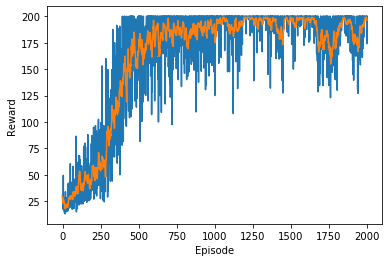

Varince of reward = 3139.7772097499997


In [11]:
plt.plot(np.mean(all_rewards, axis = 0))
plt.plot(np.mean(mean_rewards, axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(all_rewards, axis = 0))))

In [12]:
df = pd.DataFrame()
df['rewards'] = np.mean(all_rewards, axis = 0)
df['mean10_rewards'] = np.mean(mean_rewards, axis = 0)
df.to_csv('D:/Reinforcement_Learning/df_reinforce_2_trajectories_2000.csv', index=False)